In [1]:
import psycopg2
import pandas as pd
import numpy as np
import statistics as stat
from scipy.stats import norm
import matplotlib.pyplot as plt
import TickServiceConnection as TSC

In [2]:
class SparkPnL:
    
    
    def __init__(self):
        print('''
        Brief Introduction:
        PnL per trade: extract_tick_trade, PnL_trade, get_bound_trade and PnL_trade_plot;
        PnL per market: extract_tick_market, PnL_market, get_bound_market and PnL_market_plot.
        ''')
    
    
    def extract_tick_trade(self, tickdb):
        tickdb = tickdb.fillna(method='ffill')
        tickdb['mid_price'] = (tickdb['bid_price'] + tickdb['ask_price']) / 2
        tickdf = tickdb.filter(['time', 'mid_price'])
        tickdf = tickdf.drop_duplicates().sort_values(by='time')
        tickdf.reset_index(drop=True, inplace=True)
        return tickdf
 

    def extract_tick_market(self, curr_pairs, *args):
        tickdf = pd.DataFrame()
        for curr_pair, arg in zip(curr_pairs, args):
            tick_curr = self.extract_tick_trade(arg)
            tickdf[curr_pair+'_time'] = tick_curr['time']
            tickdf[curr_pair+'_mid_price'] = tick_curr['mid_price']
        tickdf.reset_index(drop=True, inplace=True)
        return tickdf

    
    def value_in_dollar(self, closing_rates, currency):
        name = currency+'USD' if currency+'USD' in list(closing_rates['currency_pair'].unique()) else 'USD'+currency
        if name not in closing_rates['currency_pair'].values:
            raise Exception("No corresponding closing rate available.")
        price = closing_rates.loc[closing_rates['currency_pair'] == name, 'closing_rate'].values[0] # consider closing price of the previous day
        price = price if name[:3] == currency else 1/price
        return price
    
    
    def PnL_trade(self, tickdf, filled_orders, closing_rates, order_id, Ts):
        trade = filled_orders.loc[filled_orders['id']==order_id,].iloc[0]
        filled_time = trade['updated_timestamp']
        curr_pair = trade['currency_pair']
        filled_price = trade['filled_price']
        side = 1 if trade['side'] == 'BUY' else -1
        standardized_qt = 1e6

        PnLs = []
        for T in Ts:
            time = filled_time + T
            tick_row_index = sum(time >= tickdf['time']) - 1
            tick_price = tickdf.iloc[tick_row_index,:]['mid_price']
            if curr_pair[-3:] == 'USD':
                pnl = side * standardized_qt * (tick_price - filled_price)
            elif curr_pair[0:3] == 'USD':
                pnl = side * standardized_qt * (tick_price - filled_price) / tick_price
            else:
                pnl = side * standardized_qt * (tick_price - filled_price) * self.value_in_dollar(closing_rates, curr_pair[-3:])
            PnLs.append(pnl)
        return PnLs
    
    
    def PnL_market(self, tickdf, filled_orders, closing_rates, market_name, currency_pairs, Ts):
    
        orders = filled_orders.loc[(filled_orders['market'] == market_name) & filled_orders['currency_pair'].isin(currency_pairs), :]
        avg_PnLs = []

        for T in Ts:

            PnLs_list = []

            for curr_pair in currency_pairs:
                
                filled_curr = orders.loc[orders['currency_pair'] == curr_pair, :].reset_index().drop('index', axis=1)
                curr_tick = tickdf.loc[:, [curr_pair+'_time', curr_pair+'_mid_price']].dropna()

                times = filled_curr['updated_timestamp'] + T
                filled_curr.loc[filled_curr['side']=='BUY', 'side'] = 1
                filled_curr.loc[filled_curr['side']=='SELL', 'side'] = -1
                sides = filled_curr['side']
                standardized_qts = 1e6
                filled_prices = filled_curr['filled_price']
                tick_row_indexes = list(times.apply(lambda x: sum(x >= curr_tick[curr_pair+'_time']) - 1))
                market_prices = curr_tick.iloc[tick_row_indexes,:][curr_pair+'_mid_price'].reset_index().drop('index', axis=1)
                           
                if curr_pair[-3:] == 'USD':
                    PnLs = list(sides * standardized_qts * (market_prices[curr_pair+'_mid_price'] - filled_prices))
                elif curr_pair[0:3] == 'USD':
                    PnLs = list(sides * standardized_qts * (market_prices[curr_pair+'_mid_price'] - filled_prices) / market_prices[curr_pair+'_mid_price'])
                else:
                    PnLs = list(sides * standardized_qts * (market_prices[curr_pair+'_mid_price'] - filled_prices) * self.value_in_dollar(closing_rates, curr_pair[-3:]))
                
                PnLs_list.extend(PnLs)

            avg_PnLs.append(stat.mean(PnLs_list))

        return avg_PnLs
    
    
    def PnL_trade_plot(self, order_id, Ts, PnL, bound, alpha):
        Ts = [T/1000 for T in Ts]
        plt.figure(figsize=(12,8))
        index_T0 = bound.index(0)
        upper = [PnL[index_T0]+b for b in bound]
        lower = [PnL[index_T0]-b for b in bound]
        plt.plot(Ts, PnL, color='blue', label='PnL')
        plt.grid(color='grey', linestyle='-.', linewidth=0.3)
        #for i,j in zip(Ts, PnL):
            #plt.text(i, j - np.max(bound)/10, str(round(j, 2)))
        plt.plot(Ts, upper, color='red', linestyle='--')
        plt.plot(Ts, lower, color='red', linestyle='--')
        plt.title('P&L for trade ' + order_id)
        plt.xlabel('T+(s)')
        plt.ylabel('Dollar Per Million Quantity')
        plt.legend(['P&L', str(alpha*100)+'% Confidence Interval'])
    
    
    def PnL_market_plot(self, market_name, currency_pairs, Ts, PnL, bound, alpha):
        Ts = [T/1000 for T in Ts]
        plt.figure(figsize=(12,8))
        index_T0 = bound.index(0)
        upper = [PnL[index_T0]+b for b in bound]
        lower = [PnL[index_T0]-b for b in bound]
        plt.plot(Ts, PnL, color='blue', label='PnL')
        plt.grid(color='grey', linestyle='-.', linewidth=0.3)
        #for i,j in zip(Ts, PnL):
            #plt.text(i, j - np.max(bound)/10, str(round(j, 2)))
        plt.plot(Ts, upper, color='red', linestyle='--')
        plt.plot(Ts, lower, color='red', linestyle='--')
        curr_pairs_string = ', '.join(currency_pairs)
        plt.title('Average P&L for market ' + market_name + ' trading ' + curr_pairs_string)
        plt.xlabel('T+(s)')
        plt.ylabel('Dollar Per Million Quantity')
        plt.legend(['Average P&L', str(alpha*100)+'% Confidence Interval'])
        
    
    def get_bound_trade(self, tickdf, filled_orders, closing_rates, order_id, Ts, alpha):
        # calculate the sigma for 1min and get PnLs for Ts by multiplying a constant
        
        trade = filled_orders.loc[filled_orders['id']==order_id,].iloc[0]
        multipliers = [abs(T/5000) for T in Ts]
        
        filled_time = trade['updated_timestamp']
        curr_pair = trade['currency_pair']
        filled_price = trade['filled_price']
        standardized_qt = 1e6
        
        end_time = filled_time
        start_time = end_time - 300000
        time_series = tickdf.loc[(tickdf['time']<=end_time) & (tickdf['time']>=start_time), :].reset_index().drop('index', axis=1)
        time_series['time'] = pd.to_datetime(time_series['time'], unit='ms')
        T0_price = time_series['mid_price'].iloc[time_series.shape[0]-1,]
        mid_price = time_series.set_index('time')
        mid_price = mid_price[~mid_price.index.duplicated(keep='first')]
        resample_mid = mid_price.resample('5s').ffill().dropna()
        
        log_return_mid_price = np.log(resample_mid / resample_mid.shift(1)).dropna().astype('float64')
        mid_std = np.std(log_return_mid_price)
                   
        if curr_pair[-3:] == 'USD':
            pnl_std = mid_std['mid_price'] * standardized_qt * T0_price
        elif curr_pair[0:3] == 'USD':
            pnl_std = mid_std['mid_price'] * standardized_qt
        else:
            pnl_std = mid_std['mid_price'] * standardized_qt * T0_price * self.value_in_dollar(closing_rates, curr_pair[-3:])
        
        bound = [np.sqrt(mul) * norm.ppf(alpha) * pnl_std for mul in multipliers]
        
        return bound

            
    def get_bound_market(self, tickdf, filled_orders, closing_rates, market_name, currency_pairs, Ts, alpha):
        # calculate the sigma for 1min and get PnLs for Ts by multiplying a constant

        orders = filled_orders.loc[(filled_orders['market'] == market_name) & filled_orders['currency_pair'].isin(currency_pairs), :]
        multipliers = [abs(T/5000) for T in Ts]

        var_list = []

        for curr_pair in currency_pairs:
            
            filled_currency = orders.loc[orders['currency_pair'] == curr_pair, :].reset_index().drop('index', axis=1)
            curr_tick = tickdf.loc[:, [curr_pair+'_time', curr_pair+'_mid_price']].reset_index().drop('index', axis=1)
            curr_var_list = []

            for i in range(filled_currency.shape[0]):

                end_time = filled_currency['updated_timestamp'].iloc[i,]
                start_time = end_time - 300000
                qts = 1e6
                time_series = curr_tick.loc[(curr_tick[curr_pair + '_time']<=end_time) & (curr_tick[curr_pair + '_time']>=start_time), :].reset_index().drop('index', axis=1)
                time_series[curr_pair + '_time'] = pd.to_datetime(time_series[curr_pair + '_time'], unit='ms')
                T0_price = time_series[curr_pair + '_mid_price'].iloc[time_series.shape[0]-1,]
                mid_price = time_series.set_index(curr_pair + '_time')
                mid_price = mid_price[~mid_price.index.duplicated(keep='first')]
                resample_mid = mid_price.resample('5s').ffill().dropna()

                log_return_mid_price = np.log(resample_mid / resample_mid.shift(1)).dropna().astype('float64')
                curr_var = np.var(log_return_mid_price)
                curr_var_list.append(curr_var[curr_pair + '_mid_price'] * qts * qts * T0_price * T0_price)
           
            if curr_pair[-3:] != 'USD':
                value = self.value_in_dollar(closing_rates, curr_pair[-3:])
                curr_var_list = [value * value * curr_var for curr_var in curr_var_list]

            var_list.extend(curr_var_list)

        std_avg = np.sqrt(np.sum(var_list)) / orders.shape[0]
        bound = [np.sqrt(mul) * norm.ppf(alpha) * std_avg for mul in multipliers]

        return bound

In [3]:
# read filled orders & closing rates
conn = psycopg2.connect(host = 'PDTY3000.ty3.sparksystems.sg',
                                database = 'kgis_db', 
                                user = 'sparksupport',
                                password = 'sparksupport',
                                port = '30101')
        
filled_orders = pd.read_sql_query(
    '''   
    select market, id, side, trade_date, updated_timestamp, order_status, currency_pair, tenor, quantity, limit_price, filled_quantity, filled_price
    from fx.fx_order
    where product_type <> 'FXSWAP' and order_status = 'FILLED' and filled_quantity > 0 and trade_date = '2021-06-22'
    ''',
    con=conn)
# filled_orders['updated_timestamp'] = pd.to_datetime(filled_orders['updated_timestamp'], unit='ms')
# filled_orders = filled_orders.reset_index().drop('index', axis=1)

closing_rates = pd.read_sql_query(
    '''
    select currency_pair, closing_rate 
    from fx.eod_rate 
    where date = '2021-06-21' and tenor = 'SP'
    ''', 
    con=conn)
# date of closing_rates can be decided by dt.datetime.strptime('2021-04-22', "%Y-%m-%d")-dt.timedelta(days = 1)).strftime("%Y-%m-%d")

# close the connetion
conn.close()

In [14]:
filled_orders.loc[filled_orders.currency_pair=='USDJPY']

,market,id,side,trade_date,updated_timestamp,order_status,currency_pair,tenor,quantity,limit_price,filled_quantity,filled_price
0,CS,BGY01083855,SELL,2021-06-22,1624318394156,FILLED,USDJPY,SP,1000.0,110.358,1000.0,110.358
1,SPARK_PRICING,BGZ070316338,SELL,2021-06-22,1624318394157,FILLED,USDJPY,SP,1000.0,NaN,1000.0,110.356
2,BAML,BGY04452225,SELL,2021-06-22,1624318394189,FILLED,USDJPY,SP,1000.0,110.359,1000.0,110.359
3,SPARK_PRICING,BGZ070316336,SELL,2021-06-22,1624318394189,FILLED,USDJPY,SP,1000.0,NaN,1000.0,110.357
4,JPMC_SG,BGY22273377,SELL,2021-06-22,1624318394225,FILLED,USDJPY,SP,1000.0,110.360,1000.0,110.360
...,...,...,...,...,...,...,...,...,...,...,...,...
1347,SPARK_PRICING,BGZ070317676,SELL,2021-06-22,1624375648645,FILLED,USDJPY,SP,1000.0,NaN,1000.0,110.759
1348,JPMC_SG,BGY22273963,SELL,2021-06-22,1624375648677,FILLED,USDJPY,SP,1000.0,110.759,1000.0,110.759
1349,JPMC_SG,BGY22273965,SELL,2021-06-22,1624375648677,FILLED,USDJPY,SP,1000.0,110.758,1000.0,110.758
1350,SPARK_PRICING,BGZ070317678,SELL,2021-06-22,1624375648677,FILLED,USDJPY,SP,1000.0,NaN,1000.0,110.757


In [6]:
filled_orders.groupby('market').agg({'market': 'count'})

,market
market,
BAML,79
BNP,35
COMZ,32
CS,273
HSBC,2
JPMC_SG,544
MS,8
SCFX,12
SPARK_PRICING,1200


In [7]:
closing_rates

,currency_pair,closing_rate
0,GBPJPY,153.72400
1,EURGBP,0.85532
2,EURJPY,131.48300
3,EURZAR,16.95510
4,USDJPY,110.31700
5,GBPUSD,1.39349
6,AUDUSD,0.75445
7,NZDUSD,0.69915
8,USDCAD,1.23612
9,USDNOK,8.57609


In [8]:
db_path = 'C:/Python Work/PnL/SparkTick'
java_home_path = 'C:/dev/tools/jdk/java-11-openjdk'
jar_path = 'C:/Python Work/PnL/sparktick-4.7.0-SNAPSHOT.jar'

TSC.startLocalSession(db_path, java_home_path, jar_path)

Connected to JVM


In [9]:
%%time
USDJPY_db = TSC.queryTickData('FULL_AMOUNT', 'USDJPY.SP', 1, '2021-06-21 13:00:00', '2021-06-23 13:00:00')
USDJPY_db

Wall time: 1min


,bid_market,bid_price,bid_size,ask_market,ask_price,ask_size,time
timestamp,,,,,,,
2021-06-21 13:00:00.072,RBOS_FA,110.128,500000.0,COMZ_FA,110.132,10000000.0,1624280400072
2021-06-21 13:00:00.069,RBOS_FA,110.129,500000.0,COMZ_FA,110.132,10000000.0,1624280400069
2021-06-21 13:00:00.169,RBOS_FA,110.129,500000.0,COMZ_FA,110.132,10000000.0,1624280400169
2021-06-21 13:00:00.095,RBOS_FA,110.129,500000.0,COMZ_FA,110.132,10000000.0,1624280400095
2021-06-21 13:00:00.150,RBOS_FA,110.129,500000.0,COMZ_FA,110.132,10000000.0,1624280400150
...,...,...,...,...,...,...,...
2021-06-23 06:27:28.113,BAML_FA,110.870,1000000.0,BAML_FA,110.878,1000000.0,1624429648113
2021-06-23 06:27:28.115,BAML_FA,110.870,1000000.0,BAML_FA,110.878,1000000.0,1624429648115
2021-06-23 06:27:28.115,BAML_FA,110.870,1000000.0,BAML_FA,110.878,1000000.0,1624429648115


In [10]:
PnL = SparkPnL()


        Brief Introduction:
        PnL per trade: extract_tick_trade, PnL_trade, get_bound_trade and PnL_trade_plot;
        PnL per market: extract_tick_market, PnL_market, get_bound_market and PnL_market_plot.
        


In [11]:
USDJPY = PnL.extract_tick_trade(USDJPY_db)
USDJPY

,time,mid_price
0,1624280400069,110.1305
1,1624280400072,110.1300
2,1624280400095,110.1305
3,1624280400126,110.1315
4,1624280400150,110.1305
...,...,...
805787,1624429648112,110.8740
805788,1624429648113,110.8740
805789,1624429648115,110.8740
805790,1624429648116,110.8740


In [18]:
%%time
order_id = 'BGY22273963' # market: CS; side: SELL; currency: USDJPY.SP; filled price:110.3580
Ts = [-2000, -1000, 0, 1000, 3000, 5000, 10000, 30000, 60000, 120000, 180000] # units are ms
pnl = PnL.PnL_trade(USDJPY, filled_orders, closing_rates, order_id, Ts) 
pnl

Wall time: 655 ms


[18.05754940992749,
 9.028693186862926,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 9.028693186862926,
 -9.028530155205527,
 -9.028530155205527,
 -212.1273666869634,
 -225.66435586358566]

In [19]:
alpha = 0.95
bound = PnL.get_bound_trade(USDJPY, filled_orders, closing_rates, order_id, Ts, alpha)
bound

[15.104042545096242,
 10.680170906967671,
 0.0,
 10.680170906967671,
 18.498598644386984,
 23.881588159295298,
 33.773665865884126,
 58.49770523756603,
 82.72824811466951,
 116.99541047513206,
 143.28952895577177]

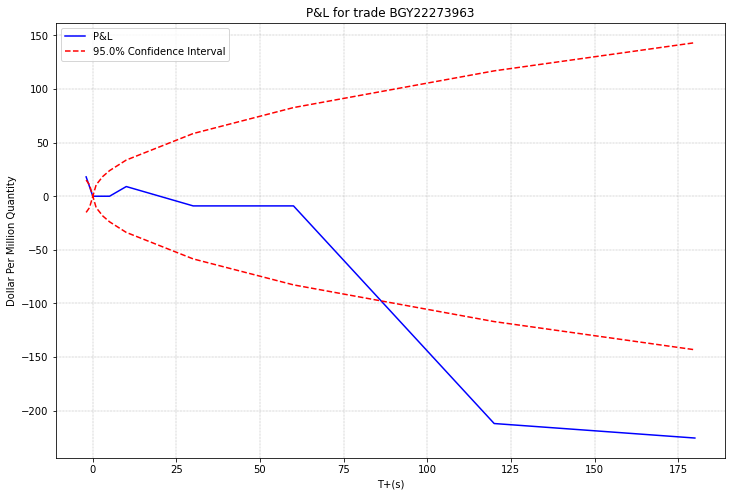

In [20]:
PnL.PnL_trade_plot(order_id, Ts, pnl, bound, alpha)

Wall time: 1min 11s


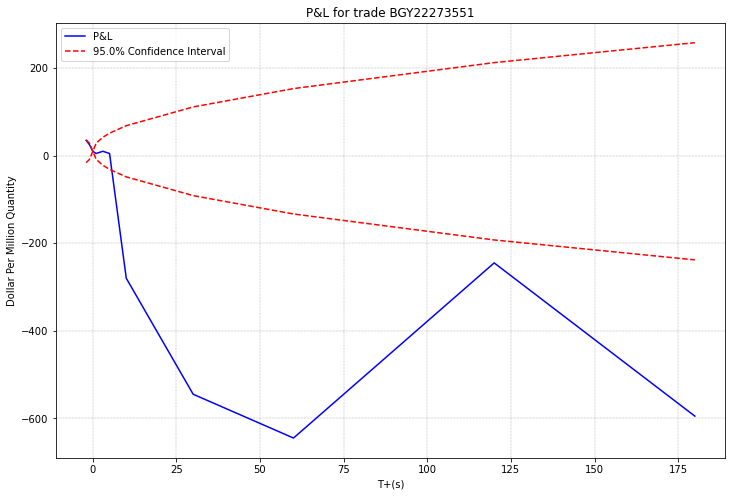

In [25]:
%%time
EURUSD_db = TSC.queryTickData('FULL_AMOUNT', 'EURUSD.SP', 1, '2021-06-21 13:00:00', '2021-06-23 13:00:00')
EURUSD = PnL.extract_tick_trade(EURUSD_db)
order_id = 'BGY22273551' # market: JPMC_SG; side: BUY; currency: EURUSD.SP; filled price:1.18JPMC_SG
pnl = PnL.PnL_trade(EURUSD, filled_orders, closing_rates, order_id, Ts) 
alpha = 0.95
bound = PnL.get_bound_trade(EURUSD, filled_orders, closing_rates, order_id, Ts, alpha)
PnL.PnL_trade_plot(order_id, Ts, pnl, bound, alpha)

Wall time: 1min 12s


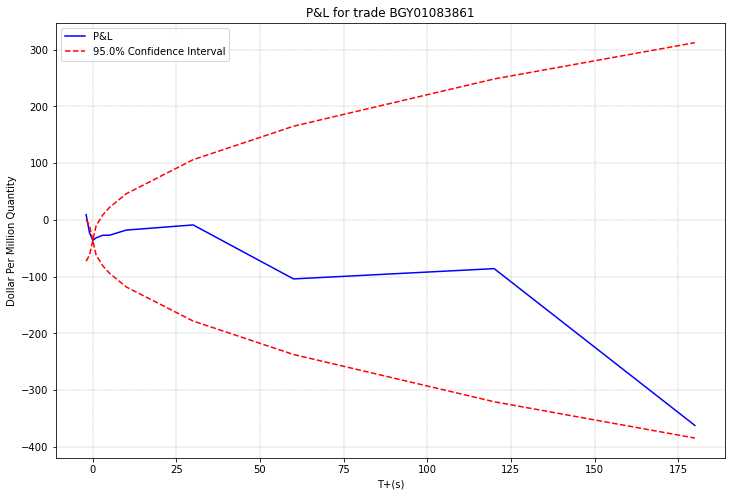

In [26]:
%%time
GBPJPY_db = TSC.queryTickData('FULL_AMOUNT', 'GBPJPY.SP', 1, '2021-06-21 13:00:00', '2021-06-23 13:00:00')
GBPJPY = PnL.extract_tick_trade(GBPJPY_db)
order_id = 'BGY01083861' # market: CS; side: SELL; currency: GBPJPY.SP; filled price:153.736
pnl = PnL.PnL_trade(GBPJPY, filled_orders, closing_rates, order_id, Ts) 
alpha = 0.95
bound = PnL.get_bound_trade(GBPJPY, filled_orders, closing_rates, order_id, Ts, alpha)
PnL.PnL_trade_plot(order_id, Ts, pnl, bound, alpha)

In [22]:
%%time
EURJPY_db = TSC.queryTickData('FULL_AMOUNT', 'EURJPY.SP', 1, '2021-06-21 13:00:00', '2021-06-23 13:00:00')
EURGBP_db = TSC.queryTickData('FULL_AMOUNT', 'EURGBP.SP', 1, '2021-06-21 13:00:00', '2021-06-23 13:00:00')
USDCAD_db = TSC.queryTickData('FULL_AMOUNT', 'USDCAD.SP', 1, '2021-06-21 13:00:00', '2021-06-23 13:00:00')
USDCHF_db = TSC.queryTickData('FULL_AMOUNT', 'USDCHF.SP', 1, '2021-06-21 13:00:00', '2021-06-23 13:00:00')
GBPUSD_db = TSC.queryTickData('FULL_AMOUNT', 'GBPUSD.SP', 1, '2021-06-21 13:00:00', '2021-06-23 13:00:00')

Wall time: 4min 43s


In [23]:
curr_pairs = ['USDJPY', 'EURUSD', 'EURJPY', 'EURGBP', 'USDCAD', 'USDCHF', 'GBPUSD']

In [24]:
%%time
tickdb_cs = PnL.extract_tick_market(curr_pairs, USDJPY_db, EURUSD_db, EURJPY_db, EURGBP_db, USDCAD_db, USDCHF_db, GBPUSD_db)
tickdb_cs

NameError: name 'EURUSD_db' is not defined

In [19]:
%%time
market_name = 'CS'
cs_pnl = PnL.PnL_market(tickdb_cs, filled_orders, closing_rates, market_name, curr_pairs, Ts)
cs_pnl

Wall time: 28.8 s


[41.01885802817608,
 25.772793832649597,
 -0.8510889131237388,
 -14.155608001818559,
 -5.199877049964399,
 -11.043242786961764,
 -7.348352545762137,
 -13.420915997170983,
 -18.327849214380375,
 -3.503443962826354,
 -24.965339855881272]

In [20]:
alpha = 0.95
cs_pnl_bound = PnL.get_bound_market(tickdb_cs, filled_orders, closing_rates, market_name, curr_pairs, Ts, alpha)
cs_pnl_bound

[6.783632279873224,
 4.796752386174316,
 0.0,
 4.796752386174316,
 8.308218844181164,
 10.725864406720094,
 15.168662912158409,
 26.272894846744048,
 37.15548421506763,
 52.545789693488096,
 64.35518644032055]

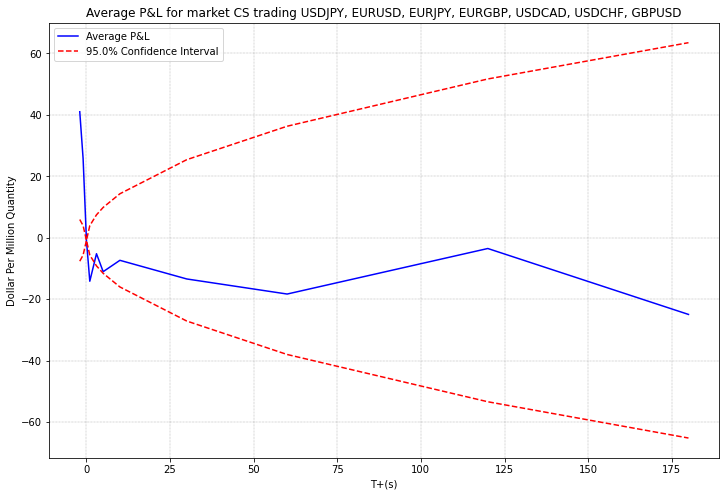

In [21]:
PnL.PnL_market_plot(market_name, curr_pairs, Ts, cs_pnl, cs_pnl_bound, alpha)